# Counting length of a string
Let's use a neural net to see if we can detect parity of a word; does it have an even or odd number of characters?

### Import the data and grok it

In [1]:
import json
from pathlib import Path

from fastai2.vision.all import *
import pandas as pd
import torch

In [2]:
# this is a list of over 370,000 "english words", from https://github.com/dwyl/english-words
# note that these aren't necessarily useful words; a lot of them seem pretty gibberish.
path = Path('/storage/data/words_dictionary.json')

In [3]:
# words is a dict object; the keys are the words, the values are irrelevant
with path.open() as f:
    words = json.load(f)

In [4]:
# we can look at some of them
from itertools import islice
print([word for word in islice(words.keys(), 10)])

['a', 'aa', 'aaa', 'aah', 'aahed', 'aahing', 'aahs', 'aal', 'aalii', 'aaliis']


In [5]:
# if we're willing to load the whole thing, we can look at random words
from random import choice, randrange, sample

word_list = list(words.keys())
print(sample(word_list, 10))

['bluebonnets', 'anobing', 'lavendering', 'ischiatic', 'samarra', 'dochmius', 'adventitious', 'sauerbraten', 'kumkum', 'myelocele']


In [6]:
# let's define some function to learn.
# here, I'm going to learn whether the word has an even or odd number of letters in it

# as applied to a word or list of words
def learn_fn(words):
    if isinstance(words, str):
        return len(words) % 2
    return [len(word) % 2 for word in words]

# as applied to a tensor
def label_fn(vec):
    return len(vec.nonzero()) % 2

def label_str(label):
    return 'odd' if label == 1 else 'even'

In [7]:
[(word, len(word), learn_fn(word)) for word in sample(word_list, 10)]

[('goatskins', 9, 1),
 ('erinnic', 7, 1),
 ('hydrostat', 9, 1),
 ('pharmacodynamical', 17, 1),
 ('annelids', 8, 0),
 ('trihemimer', 10, 0),
 ('cryst', 5, 1),
 ('mudroom', 7, 1),
 ('cannelated', 10, 0),
 ('antipapist', 10, 0)]

In [8]:
# let's try image techniques. Can get common-length numerical vectors using 
# ascii encoding of characters in the string, and 0-pad up to the maximum
# word-length present in the dataset.

# NOTE: for this dataset, we find maxlen = 31
maxlen = max(len(word) for word in words)
word_vecs = [
    tensor([ord(c) for c in word] + [0] * (maxlen - len(word)))
    for word in words.keys()
]

In [9]:
# get the word back

def vec2word(vec):
    return ''.join(chr(n) for n in vec if n > 0)

vec2word(choice(word_vecs))

'yahooisms'

In [10]:
# sanity check that we built the thing right

# should find that each vec has the same length
from collections import Counter
print(Counter(len(vec) for vec in word_vecs))

# should find that the entries correspond to the letters of the word
w = choice(word_vecs)
print(f'{vec2word(w)}\n{w}')

Counter({31: 370101})
outmaster
tensor([111, 117, 116, 109,  97, 115, 116, 101, 114,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0])


### construct training and validation sets

In [11]:
# if we treat the words as "images", we want the entries to be in [0,1]; that means we need to know
# how large the entries can be. As they are ascii ord() values for characters in [a:z], we just need to 
# scale by ord(z)
maxchar = ord('z')
maxchar

122

In [12]:
# the tensors we construct need to be returned to integers before displaying
def tens2word(tens):
    return ''.join(chr(n * maxchar) for n in tens if n > 0)

In [13]:
# lets construct a training and validation set
# (normally we should be careful to split each class into training/validation;
# here the classes are large and of about equal size so we should be fine)

words_range = range(len(words))
valid_inds = sample(words_range, int(0.2 * len(words)))
valid_set = set(valid_inds)
train_inds = [ind for ind in words_range if ind not in valid_set]

words_stack = torch.stack(word_vecs).float()/maxchar
train_stack = words_stack[train_inds]
valid_stack = words_stack[valid_inds]

### baseline using pointwise distance to mean

In [14]:
# separate the odds and evens out in our training set
odds = words_stack[[i for i in train_inds if label_fn(word_vecs[i]) == 1]]
evens =  words_stack[[i for i in train_inds if label_fn(word_vecs[i]) == 0]]

# the size of a datapoint will be the total number of letters possible; maxlen from earlier
print(f'all: {words_stack.size()}')
print(f'train: {train_stack.size()}')
print(f'odd train: {odds.size()}')
print(f'even train: {evens.size()}')

all: torch.Size([370101, 31])
train: torch.Size([296081, 31])
odd train: torch.Size([147774, 31])
even train: torch.Size([148307, 31])


In [15]:
# let's visualize the mean values for each class
train_mean = train_stack.mean(0)
odd_mean = odds.mean(0)
even_mean = evens.mean(0)
df = pd.DataFrame({'train': train_mean, 'odd': odd_mean, 'even': even_mean})
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,train,odd,even
0,0.882270,0.883672,0.883835
1,0.882097,0.882026,0.882161
2,0.885592,0.886332,0.884615
3,0.875855,0.871926,0.879836
4,0.859098,0.872052,0.846049
5,0.820815,0.796285,0.845148
6,0.750098,0.794717,0.705674
7,0.650994,0.597314,0.704510
8,0.527447,0.595535,0.459653
9,0.399765,0.341772,0.457541


In [16]:
# we can use MSE between means as a metric.
ind = randrange(words_stack.size(0))
vec = words_stack[ind]
print(f'{word_list[ind]} is {label_str(label_fn(vec))}. odd mse: {F.mse_loss(vec, odd_mean):.4f}, even mse: {F.mse_loss(vec, even_mean):.4f}')

oftest is even. odd mse: 0.0540, even mse: 0.0511


In [76]:
# overall performance by comparing to mean via MSE
# don't see an obvious way to use mse_loss on stack vs. individual (i.e., the broadcast semantics)
def word_dist(a,b):
    return ((a - b)**2).mean(-1).sqrt()

def is_odd(x):
    return word_dist(x, odd_mean) < word_dist(x, even_mean)

In [77]:
# classes are same size so it's not insane to be lazy and average validation accuracy
odds_valid = words_stack[[i for i in valid_inds if label_fn(word_vecs[i]) == 1]]
evens_valid =  words_stack[[i for i in valid_inds if label_fn(word_vecs[i]) == 0]]

odd_accuracy = is_odd(odds_valid).float().mean()
even_accuracy = (1 - is_odd(evens_valid).float()).mean()

odd_accuracy, even_accuracy, (odd_accuracy + even_accuracy)/2

(tensor(0.9285), tensor(0.9186), tensor(0.9236))

not bad! ~92% accuracy

### train a fastai Learner

In [39]:
# Let's construct Dataloaders for our training and validation sets
dl_train = DataLoader(L((tens, label_fn(tens)) for tens in train_stack), batch_size=64, shuffle=True)
dl_valid = DataLoader(L((tens, label_fn(tens)) for tens in valid_stack), batch_size=64)
dls = DataLoaders(dl_train, dl_valid)

In [47]:
# let's examine a batch from a DataLoader
[(tens2word(tens), label.item()) for (tens, label) in zip(*first(dls.valid))]

[('terrification', 1),
 ('nonregeneratively', 1),
 ('discontinuousness', 1),
 ('anamirta', 0),
 ('blockheads', 0),
 ('poloniums', 1),
 ('lethargise', 0),
 ('summering', 1),
 ('ponderosity', 1),
 ('brulyie', 1),
 ('daters', 0),
 ('macklike', 0),
 ('cutdowns', 0),
 ('overcapitalisation', 0),
 ('mechanisms', 0),
 ('chargeful', 1),
 ('monophthongized', 1),
 ('componented', 1),
 ('counteractivity', 1),
 ('prosogaster', 1),
 ('albuminoidal', 0),
 ('yuletides', 1),
 ('fundamentalness', 1),
 ('nonenclosure', 0),
 ('cantankerously', 0),
 ('gloomed', 1),
 ('heliophobous', 0),
 ('odoriferous', 1),
 ('tacheography', 0),
 ('vardy', 1),
 ('enlisting', 1),
 ('unburied', 0),
 ('unattemptable', 1),
 ('banksia', 1),
 ('cowl', 0),
 ('sexdigitism', 1),
 ('blastophitic', 0),
 ('delinter', 0),
 ('gnocchetti', 0),
 ('purpose', 1),
 ('scimitared', 0),
 ('albify', 0),
 ('leadenhearted', 1),
 ('indigenous', 0),
 ('bismutoplagionite', 1),
 ('disclike', 0),
 ('assaulting', 0),
 ('psha', 0),
 ('rabinet', 1),
 ('tr

#### first via linear regression

In [78]:
linear_model = nn.Linear(maxlen, 1)
learn = Learner(dls, linear_model, opt_func=SGD, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.5))
learn.fit(10, lr=1.)


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.043920,0.043580,0.993353,00:12
1,0.027975,0.028287,0.995609,00:12
2,0.025467,0.023737,0.995947,00:12
3,0.017110,0.018773,0.997149,00:12
4,0.016067,0.016103,0.997568,00:12
5,0.015770,0.014778,0.997717,00:12
6,0.012510,0.013062,0.998055,00:12
7,0.011856,0.012243,0.998176,00:11
8,0.012258,0.011217,0.998325,00:12
9,0.012975,0.010493,0.998460,00:12


Nice! 99.8% accuracy already

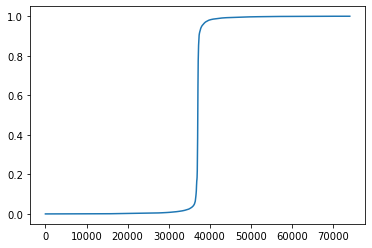

In [79]:
import matplotlib.pyplot as plt
%matplotlib inline

# check out that the validation scores are quite far from 0.5
(out, tar) = learn.get_preds(dl = dl_valid)
plt.plot(sorted(out))

#### next via a neural net with one hidden layer

0.2290867567062378 1.5848931980144698e-06


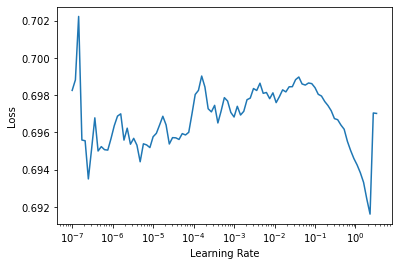

In [85]:
nn_model = nn.Sequential(
    nn.Linear(maxlen, 50),
    nn.ReLU(),
    nn.Linear(50, 1)
)
learn = Learner(dls, nn_model, opt_func=SGD, loss_func=BCEWithLogitsLossFlat(), metrics=partial(accuracy_multi, thresh=0.5))

# let's find an optimal learning rate
lr_min, lr_steep = learn.lr_find()
print(lr_min, lr_steep)


In [87]:
# finally, let's train the neural net
learn.fit(50, lr=0.25)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.010059,0.010976,0.998082,00:12
1,0.003590,0.005045,0.999189,00:12
2,0.002356,0.003076,0.999487,00:12
3,0.001330,0.002301,0.999554,00:12
4,0.000968,0.001890,0.999716,00:12
5,0.001132,0.001511,0.999784,00:12
6,0.000847,0.001356,0.999784,00:12
7,0.000714,0.001332,0.999797,00:12
8,0.000881,0.001113,0.999811,00:13
9,0.002224,0.001968,0.999784,00:15


and finally, we get almost 99.999% accuracy!